In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transform = transforms.ToTensor() 

train_data_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 77446410.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 2621871.21it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 18644634.05it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3997173.47it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_data_set


Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data_set

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_data_set, batch_size=100, shuffle=False)

In [7]:
class CNN1(nn.Module):
    def __init__(self,):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, strides=2 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(320, 50) #((I/P - Filter + 2*Pad)/Stride)+1 
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN   
        x = self.dropout(x)   
        x = F.relu(self.fc2(x))        #Fully Connected NN           
        x = self.fc3(x)                #O/P Layer       
        return x

In [10]:
def trainFunc(model, num_epochs):
    model.train()
    n_total_steps = len(train_loader)
    train_losses = []
    train_epoch = []
    train_acc = []
    not_converged = True
    epoch = 0
    trainAvgLossArr = []
    
    while not_converged:
        epoch += 1
        n_correct = 0
        n_samples = 0
        lossSum = 0

        for i, (images, labels) in enumerate(train_loader):  
            # Forward pass
            prediction = model(images)
            loss = loss_func(prediction, labels)
            lossSum += loss.detach().numpy()
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(prediction.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()
            acc = 100.0 * n_correct / n_samples

            if (i+1) % 100 == 0:
                print (f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}', end='\r', flush=True)
                train_epoch.append(epoch)
                train_losses.append(loss.item())
                print(f'Epoch [{epoch}/{num_epochs}], Accuracy : {acc} %', end='\r', flush=True)
                train_acc.append(acc)

                if epoch == num_epochs:
                    print(f"Max Epoch Reached, Loss: {loss.item():.4f}, Accuracy: {acc:.2f}%")
                    not_converged = False
                elif (epoch > 5) and (train_losses[-1] < 0.001):
                    if abs(train_losses[-3] - train_losses[-2]) < 1.0e-05 and abs(train_losses[-2] - train_losses[-1]) < 1.0e-05:
                        print("Convergence reached for loss:", train_losses[-1])
                        not_converged = False

        trainAvgLossArr.append(lossSum / (i+1))
        
    return train_epoch, train_losses, train_acc, trainAvgLossArr


In [11]:
input_size = 784 # 28x28
max_epochs = 15
learning_rate = 0.001
kernel_size = 4
weight_decay_val = 1e-4
dropout = 0.25

In [12]:
torch.manual_seed(1)

cnn1 = CNN1()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn1.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]
for i in cnn1.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 1:', np.sum(a),)

Total no of parameters in Model 1: 25550


In [13]:
train_epoch,train_losses,train_acc,trainAvgLossArr =trainFunc(cnn1,max_epochs)

/home/skomara/.local/lib/python3.9/site-packages/torch/autograd/graph.py:769: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Max Epoch Reached, Loss: 0.0466, Accuracy: 98.22%


In [15]:
def testFunc (model):
    model.eval()
    with torch.no_grad():
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(10)]
        n_class_samples = [0 for i in range(10)]
        for test_images, test_labels in test_loader:
            outputs = model(test_images)
            _, predicted = torch.max(outputs, 1)
            n_samples += test_labels.size(0)
            n_correct += (predicted == test_labels).sum().item()
            
            for i in range(100):
                label = test_labels[i]
                pred = predicted[i]
                if (label == pred):
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        netTest_acc1 = 100.0 * n_correct / n_samples
        print(f'Accuracy of the network: {netTest_acc1} %')

    
    return netTest_acc1

In [16]:
cnn1TestAcc = testFunc(cnn1)

Accuracy of the network: 98.67 %


In [17]:
class CNN2(nn.Module):
    def __init__(self,):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size) #1st Convolution
        self.pool = nn.MaxPool2d(2, 2)   #pool_size=2, 
        self.conv2 = nn.Conv2d(10, 20, kernel_size) #2nd Convolution
        self.fc1 = nn.Linear(20*kernel_size*kernel_size, 50) 
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,40)
        self.fc4 = nn.Linear(40,30)
        self.fc5 = nn.Linear(30, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 320)            #Flattening 
        x = F.relu(self.fc1(x))        #Fully Connected NN       
        x = F.relu(self.fc2(x))        #Fully Connected NN 
        x = F.relu(self.fc3(x))        #Fully Connected NN 
        x = F.relu(self.fc4(x))        #Fully Connected NN
        x = self.fc5(x)                #O/P Layer       
        return x

In [18]:
torch.manual_seed(1)

cnn2 = CNN2()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn2.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn2.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 2:', np.sum(a),)

Total no of parameters in Model 2: 25570


In [19]:
train_epoch2,train_losses2,train_acc2,trainAvgLossArr2=trainFunc(cnn2,max_epochs)

Max Epoch Reached, Loss: 0.0843, Accuracy: 98.00%


In [20]:
cnn2TestAcc = testFunc(cnn2)

Accuracy of the network: 98.24 %


In [21]:
class CNN3(nn.Module):
    def __init__(self,): 
        super(CNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 15, 5)
        self.fc1 = nn.Linear(15*4*4, 84)
        self.fc2 = nn.Linear(84, 10)
       

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
     
        x = x.view(-1, 15*4*4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [22]:
torch.manual_seed(1)

cnn3 = CNN3()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn3.parameters(), lr=learning_rate, weight_decay = weight_decay_val)

a=[]

for i in cnn3.parameters():
    a.append(torch.numel(i))
print('Total no of parameters in Model 3:', np.sum(a))


Total no of parameters in Model 3: 25119


In [23]:
train_epoch3,train_losses3,train_acc3,trainAvgLossArr3=trainFunc(cnn3,max_epochs)


Max Epoch Reached, Loss: 0.0561, Accuracy: 98.96%


In [25]:
cnn3TestAcc = testFunc(cnn3)

Accuracy of the network: 98.95 %


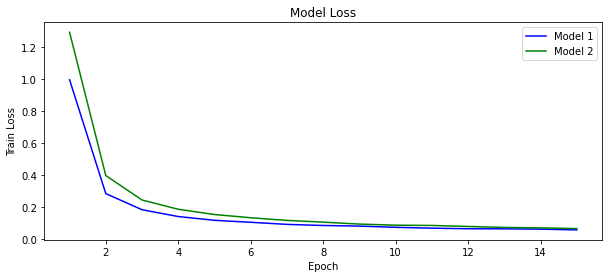

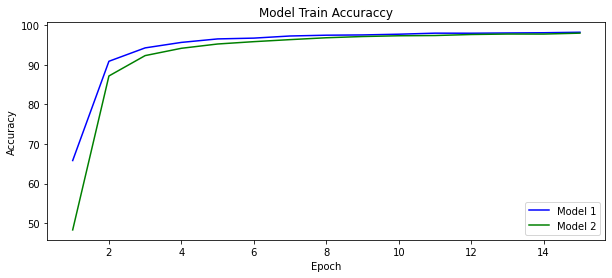

CNN1 Test Accuracy: 98.67 % 
CNN2 Test Accuracy: 98.24 % 
CNN3 Test Accuracy: 98.95 %


In [31]:
plt.figure(figsize=(10,4))
plt.plot(train_epoch,trainAvgLossArr, color = "b")
plt.plot(train_epoch2,trainAvgLossArr2, color = "g")

plt.title('Model Loss')
plt.legend(['Model 1', 'Model 2',])
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
# plt.savefig('EpochVSLoss.png')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(train_epoch,train_acc,color="b")
plt.plot(train_epoch2,train_acc2,color="g")

plt.title('Model Train Accuraccy')
plt.legend(['Model 1', 'Model 2'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.savefig('Model_Prediction.png')
plt.show()

print('CNN1 Test Accuracy:',cnn1TestAcc,'%','\nCNN2 Test Accuracy:',cnn2TestAcc,'%','\nCNN3 Test Accuracy:',cnn3TestAcc,'%')